In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
import ugradio
from tqdm import tqdm
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

No module named 'rtlsdr'


# Load in Raw Data

In [3]:
moon_data = np.load("data/moon.npy")
data = np.array([moon_data[1,:], moon_data[0,:]])
data = data[:,100:]

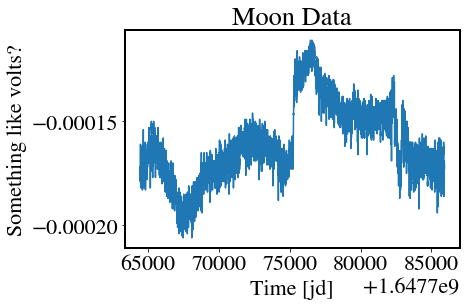

In [4]:
plt.plot(data[0], data[1])
plt.title("Moon Data")
plt.xlabel("Time [jd]")
plt.ylabel("Something like volts?")
plt.show()

## $\chi^2$ Analysis

This is an argument inside the next equation. It depends on a whole bunch of stuff $(B_{ew}, B_{ns}, \delta, h_s)$ which we will define in the cell below. We are most interested in $B_{ew}, B_{ns}$, the frequency of the trig functions is

$$\nu \tau_g'(B_{ew}, B_{ns}, \delta, h_s) = \left[{B_{ew} \over \lambda} \cos \delta \right] \sin h_s 
  + \left[{B_{ns} \over \lambda} \sin L \cos \delta \right] \cos h_s$$


We need to explore parameter space by making a grid of $B_{ew}, B_{ns}$ and curve fitting at each combo to yield a $\chi^2$ value for each combination. We will be fitting for $A,B$ but we don't care about those at all. This will allow us to fit the fringe amplitude. As long as we stay within 1 bessel envelope node we should be fine, so the 1 hour data should be just fine.

$$F(h_s) = A \cos \left(2 \pi \nu \tau_g' \right) 
         +B \sin \left(2 \pi \nu \tau_g' \right)$$
         
 

In [14]:
# L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
# λ = 2.5 / 100 # 2.5 cm

# jds = data[0] / 86400 + 2440587.5 #julian dates
# pos = np.array([[ugradio.coord.sunpos(jd)] for jd in jds]) #takes a long time to compute
# α,δ = pos[:, 0, 0], pos[:, 0, 1]

# LSTs = ugradio.timing.lst(jds) #feed in an array of julian dates observed.
# h_s = LSTs - α #create array of hour angles

# #in the mean time we create h_s just by a linspace
# h_s

import astropy.constants as con
import astropy.units as u

val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value

L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
# λ = 2.77 / 100 # 2.77 cm

jds=ugradio.timing.julian_date(data[0])
α,δ =ugradio.coord.moonpos(jds[0])
δ=(np.pi/180)*δ

LSTs = ugradio.timing.lst(jds,lon=long) #feed in an array of julian dates observed.

h_s = LSTs-α*(np.pi/180) 
print(h_s)

[-0.41838964 -0.41831671 -0.4182438  ...  1.14751919  1.14759211
  1.14766503]


In [33]:
(δ * 180/np.pi)

351.7234274360169

In [8]:
h_s

array([-3.11842803, -3.11835511, -3.11828219, ..., -1.5525192 ,
       -1.55244628, -1.55237336])

In [9]:
# h_s = np.linspace(h_s[0],(h_s[0]+15*(np.pi/180)),len(jds)) #h_s for 1hr sun data 
h_s = np.linspace(h_s[0],(h_s[0]+(15*6*(np.pi/180))),len(jds)) #h_s for 6hr sun data

# Splitting Up the 6 Hr Data

In [10]:
#model functions
def ν_τg(h_s, B_ew, B_ns, δ, λ):
    return (((B_ew / λ) * np.cos(δ)) * np.sin(h_s) + ((B_ns / λ) * np.sin(L) * np.cos(δ)) * np.cos(h_s))

def fringe_model(ν_τg, A, B):
    return A * np.cos(2 * np.pi * ν_τg) + B * np.sin(2 * np.pi * ν_τg)
    

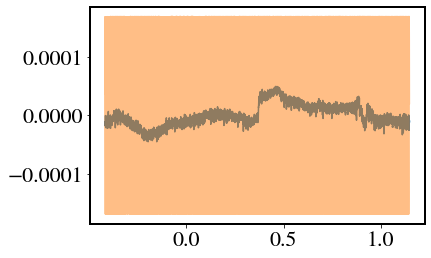

In [17]:
v = ν_τg(h_s, 14.709, 1.830, δ, λ)

plt.plot(h_s, data[1]-np.mean(data[1]))
plt.plot(h_s, fringe_model(v, 0.00012, 0.00012), alpha=0.5)
# plt.plot(h_s[4250:9000], fringe_model(v, 0.00012, 0.00012)[4250:9000], alpha=0.5)
# plt.plot(h_s[9000:15500], fringe_model(v, 0.00012, 0.00012)[9000:15500], alpha=0.5)

plt.show()

In [18]:
# lobe_1 = np.array([h_s[900:3550], (data[1][900:3550]-np.mean(data[1][900:3550]))])
# lobe_2 = np.array([h_s[4850:7500], (data[1][4850:7500]-np.mean(data[1][4850:7500]))])
# lobe_3 = np.array([h_s[9600:14500], (data[1][9600:14500]-np.mean(data[1][9600:14500]))])

lobe_1hr = np.array([h_s, (data[1]-np.mean(data[1]))])


In [11]:
v = ν_τg(lobe_1hr[0], 14.7106, 1.820, δ, λ)

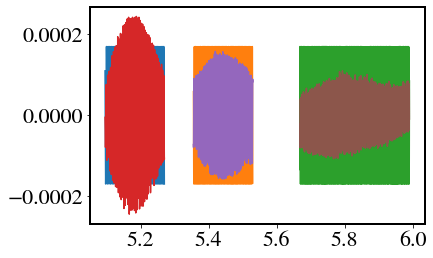

In [125]:

v = ν_τg(lobe_1[0], 14.7106, 1.820, δ, λ)
plt.plot(lobe_1[0], fringe_model(v, 0.00012, 0.00012))
v = ν_τg(lobe_2[0], 14.7106, 1.820, δ, λ)
plt.plot(lobe_2[0], fringe_model(v, 0.00012, 0.00012))
v = ν_τg(lobe_3[0], 14.7106, 1.820, δ, λ)
plt.plot(lobe_3[0], fringe_model(v, 0.00012, 0.00012))
plt.plot(lobe_1[0],lobe_1[1])
plt.plot(lobe_2[0],lobe_2[1])
plt.plot(lobe_3[0],lobe_3[1])
plt.show()

In [126]:
#create grid of baseline values
resolution = 40

### Compute $\chi^2$

Note: this is SLOW, reduce resolution to speed up

In [21]:
def compute_χ_sq(data, resolution):
    
    B_EW = 14.7099
    B_NS = 1.8297
    
    ydata = data[1]
    h_s = data[0]
    decs = np.linspace(δ - 10, δ + 10, resolution)
    
    χ_sq = np.zeros(decs.shape)
    χ_sq_r = np.zeros(decs.shape)
    sigma = .00003
    
    
    for i in tqdm(range(len(decs))):
        vs = ν_τg(h_s, B_EW, B_NS, decs[i], λ)  # Try new baselines
        p0 = np.array([0.0002,0.0003]) # A, B Guesses
        params, cov = scipy.optimize.curve_fit(fringe_model, vs, ydata, p0)
        chi_squared = np.sum(((fringe_model(vs, *params)-ydata)/sigma)**2)
        reduced_chi_squared = (chi_squared)/(len(vs)-len(params))
        χ_sq[i] = chi_squared
        χ_sq_r[i] = reduced_chi_squared
            
            
#     np.save("data/chi_sq_" + file_name + ".npy", χ_sq)
#     np.save("data/chi_sq_r_" + file_name + ".npy", χ_sq_r)
    
    return χ_sq, χ_sq_r

In [25]:
xmin,xmax = 14.708, 14.712
ymin,ymax = 1.81,1.86
res = 1000

χ_sq_1, χ_sq_r_1 = compute_χ_sq(lobe_1hr, res)
# χ_sq_2, χ_sq_r_2 = compute_χ_sq(lobe_2, res, xmin, xmax, ymin, ymax)
# χ_sq_3, χ_sq_r_3 = compute_χ_sq(lobe_3, res, xmin, xmax, ymin, ymax)


100%|██████████| 1000/1000 [00:17<00:00, 57.96it/s]


In [26]:
χ_sq_final = χ_sq_1 #+ χ_sq_2 + χ_sq_3

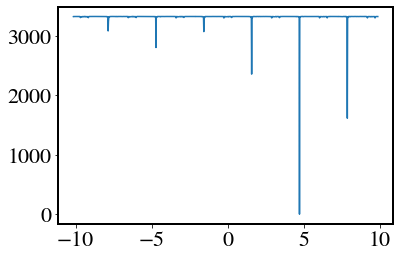

In [29]:
decs = np.linspace(δ - 10, δ + 10, res)
plt.plot(decs,χ_sq_final - np.min(χ_sq_final))

### Plot!

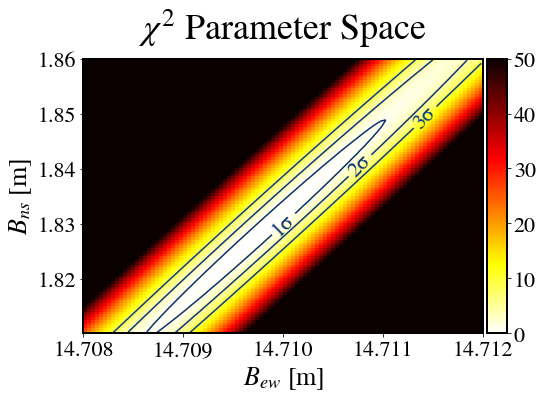

In [109]:

# χ_sq_R = np.load("data/chi_sq_r_6hr_sun.npy")

extent=[xmin, xmax, ymin, ymax]
levels = [1, 4, 9]
f, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title("$\chi^2$ Parameter Space",pad=20, fontsize=36)

cs = ax.contour(χ_sq_final - np.min(χ_sq_final), 
                levels, cmap="Blues_r", origin='lower',linewidths=1.5, extent=extent, vmax=150)

fmt = {}
strs = ['1σ', '2σ', '3σ']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

    
man = [[14.710,1.83],[14.7108,1.84],[14.7118,1.843]]
plt.clabel(cs, cs.levels, fmt=fmt, inline=1, fontsize=22, manual=man)    

im = ax.imshow(χ_sq_final - np.min(χ_sq_final), origin="lower",
               extent=extent, cmap="hot_r", aspect="auto", vmax=50)


# im = ax.imshow(χ_sq_r_2, origin="lower",extent=extent, cmap="hot_r", aspect="auto")
ax.set_xlabel("$B_{ew}$ [m]", fontsize=26)
ax.set_ylabel("$B_{ns}$ [m]", fontsize=26)
ax.set_ylim(ymin+0.0001, ymax)
ax.set_xlim(xmin,xmax)


divider1 = axgrid.make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size='5%', pad=0.05)
plt.colorbar(im, cax=cax1)
plt.tight_layout()
# plt.savefig("chi_sq_baseline_1hr.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [110]:
# χ_sq_final_r_bf = np.max(χ_sq_final / (len(lobe_1[0]) + len(lobe_2[0]) + len(lobe_3[0]) - 2))
# print(f"We report a reduced χ^2 value for the best fit of {χ_sq_final_r_bf}")

χ_sq_final_r_bf = np.max(χ_sq_final / (len(lobe_1hr[0]) - 2))
print(f"We report a reduced χ^2 value for the best fit of {χ_sq_final_r_bf}")

We report a reduced χ^2 value for the best fit of 1.4305574349044958


In [111]:
def compute_sigma(χ_sq, resolution, xmin, xmax, ymin, ymax, nσ):
    
    shifted = χ_sq - np.min(χ_sq) 
    
    B_ew, B_ns = np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution)
    B_EW, B_NS = np.meshgrid(B_ew, B_ns)

    xs = np.where(np.isclose(shifted, nσ**2, rtol=1e-1))[0][:]
    ys = np.where(np.isclose(shifted, nσ**2, rtol=1e-1))[1][:]

    max_B_ew, min_B_ew = np.max(B_EW[xs,ys]),np.min(B_EW[xs,ys])
    max_B_ns, min_B_ns = np.max(B_NS[xs,ys]),np.min(B_NS[xs,ys])

    bf_B_ew = B_EW[np.where(shifted == np.min(shifted))][0]
    bf_B_ns = B_NS[np.where(shifted == np.min(shifted))][0]

    print("The North-South Baseline is {0:0.4f} + {1:0.4f} - {2:0.4f} [m] to {3}σ".format(bf_B_ns, 
                                                                                  max_B_ns - bf_B_ns, 
                                                                                  bf_B_ns - min_B_ns, nσ))

    print("The East-West Baseline is {0:0.4f} + {1:0.4f} - {2:0.4f} [m] to {3}σ".format(bf_B_ew, 
                                                                                  max_B_ew - bf_B_ew, 
                                                                                  bf_B_ew - min_B_ew, nσ))

    
compute_sigma(χ_sq_final, res , xmin, xmax, ymin, ymax, 2)
    

The North-South Baseline is 1.8297 + 0.0303 - 0.0192 [m] to 2σ
The East-West Baseline is 14.7099 + 0.0020 - 0.0014 [m] to 2σ
